<a href="https://colab.research.google.com/github/spatank/CIS-522/blob/main/Homework/HW_7_SPP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS-522 Week 7 Homework


**Instructor:** Konrad Kording

**Content Creator:** Ben Heil

---
## Preface
Since this week's homework requires coding, we recommend saving this notebook in your google Drive (`File -> Save a copy in Drive`), and share the link to the final version in the subscription airtable form. You can also attach the code to the form if you prefer off-colab coding.

In [1]:
#@markdown What is your Pennkey and pod? (text, not numbers, e.g. bfranklin)
my_pennkey = 'spatank' #@param {type:"string"}
my_pod = 'sublime-newt' #@param ['Select', 'euclidean-wombat', 'sublime-newt', 'buoyant-unicorn', 'lackadaisical-manatee','indelible-stingray','superfluous-lyrebird','discreet-reindeer','quizzical-goldfish','astute-jellyfish','ubiquitous-cheetah','nonchalant-crocodile','fashionable-lemur','spiffy-eagle','electric-emu','quotidian-lion', 'quantum-herring']

import time
t0 = time.time()

## Setup

In [2]:
# imports
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm
from IPython import display
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


## Part 1: Reading
For this week's reading portion, we'll have you read the [original AlexNet paper](https://papers.nips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf). As you read it, be sure to notice how many features of modern state of the art networks are already present in AlexNet. For example, they use ReLU for their activation function, use data augmentation, and learning rate decay. They also foreshadow the successes and challenges of deep learning with the line "Thus
far, our results have improved as we have made our network larger and trained it longer but we still
have many orders of magnitude to go in order to match the infero-temporal pathway of the human
visual system". 

A side note on the growth of compute power over time: AlexNet was trained on two Nvidia GTX 580s, which were top of the line graphics cards for their time. Their theoretical processing speed is roughly [1.6 Trillion](https://www.techpowerup.com/gpu-specs/geforce-gtx-580.c270) Floating point Operations Per Second (TFLOPS). This year's iPhone graphics cards have a theoretical speed of [.8 TFLOPS](https://www.cpu-monkey.com/en/cpu-apple_a14_bionic-1693). That is to say that if you were to go back in time ten years with four iPhones, you could conduct cutting edge deep learning research with them.

To what extent have the gains in computer vision performance over the past ten years been due to new ideas as opposed to increases in computational power enabling the scaling of old ideas?

In [4]:
developments = '' #@param {type:"string"}

## Part 2: Implementation
As it turns out, AlexNet is representative of how many convolutional neural networks are implemented. We'll have you implement [version 2 of AlexNet](https://arxiv.org/abs/1404.5997) so you don't have to worry about paralellizing across GPUs.

Because the architecture details in the paper are largely left in footnotes, we'll provide it below:

Convolutional Block:

1.   Five [convolutional layers](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) with output filter counts of 64, 192, 384, 256, and 256 respectively. Their associated kernel sizes are 11, 5, 3, 3, 3. Their strides are 4, 2, 2, 1, 1. Finally, the first two layers have a padding of 2, while the last three have a padding of 1.
2.   [Max pooling](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) layers after the first, second, and last layer. Each pooling step has a kernel of size 3 and a stride of 2.
3.   ReLU nonlinearities after each layer

Average Pooling:  
After the convolutional block but before the classifier block, there is an [average pooling](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html) layer with an output shape of (6,6).

Classifier Block:

1.   The model uses three [fully-connected](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) layers. Their outputs are all of size 4096, 4096, and 10.
2.   There are [dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) with probability .5 before each of the first two fully connected layers.
3.   Finally, there is a ReLU after each fully-connected layer except the last one.


Note:  
When developing neural networks the size of each layer is an architecture choice, but the input to each layer is dependent solely on the input data or the output of the previous layer. To simulate this reality, we haven't provided the input shapes that will be required for the convolutional and fully-connected layers.

Tips:
- If you are unsure of what size the input should be, the shape of the output for each layer can be found in the `forward` function using the line `print(<prev_output>.shape)`
- In Pytorch image tensors have the shape (batch size, channel count, image height, image width)
- Conv layers expeect image tensors, but fully-connected layers expect flattened tensors (tensors with shape (batch size, dimension). You'll need to convert the shape at some point using [\<output_tensor\>.view(-1, dimension)](https://pytorch.org/docs/stable/tensors.html#torch.Tensor.view) or [torch.flatten](https://pytorch.org/docs/stable/generated/torch.flatten.html).



In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes: int = 1000) -> None:
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 11, stride = 4, padding = 2 ),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(64, 192, kernel_size = 5, stride = 2, padding = 2),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
            nn.Conv2d(192, 384, kernel_size = 3, stride = 2, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(384, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.Conv2d(256, 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(inplace = True),
            nn.MaxPool2d(kernel_size = 3, stride = 2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

## Part 3: Evaluation
Test how your model predicts Imagenette classes

In [6]:
# @title Download imagenette
!rm -r imagenette*
!wget https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
!tar -xf imagenette2-320.tgz
!rm -r imagenette2-320.tgz

rm: cannot remove 'imagenette*': No such file or directory
--2021-03-16 01:59:55--  https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-320.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.17.38
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.17.38|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 341663724 (326M) [application/x-tar]
Saving to: ‘imagenette2-320.tgz’

imagenette2-320.tgz 100%[===================>] 325.83M  35.1MB/s    in 9.9s    

2021-03-16 02:00:05 (32.8 MB/s) - ‘imagenette2-320.tgz’ saved [341663724/341663724]



In [7]:
# @title Prepare Imagenette Data
val_transform = transforms.Compose((transforms.Resize((224, 224)),
                                     transforms.ToTensor()))    

imagenette_val = ImageFolder('imagenette2-320/val', transform=val_transform)

train_transform = transforms.Compose((transforms.Resize((224, 224)),
                                     transforms.ToTensor()))    

imagenette_train = ImageFolder('imagenette2-320/train', transform=train_transform)

In [8]:
imagenette_train_loader = torch.utils.data.DataLoader(imagenette_train, 
                                                      batch_size=16,
                                                      shuffle=True)

imagenette_val_loader = torch.utils.data.DataLoader(imagenette_val, 
                                                    batch_size=16, 
                                                    shuffle=True)

### Test Model Training

One good way to make sure your model is performing correctly is to train it to overfit a single batch. If this loop works correctly, then the model is at least able to update its weights and produce an output.

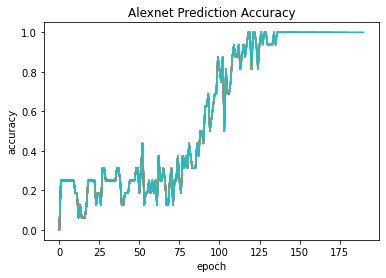

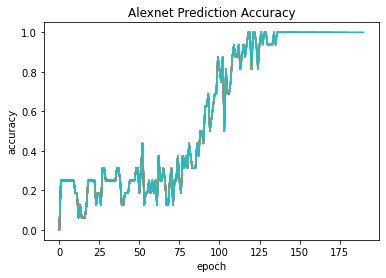

In [9]:
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

# Overfit a single batch
batch = next(iter(imagenette_train_loader))

accuracies = []
for epoch in range(200):

    # Train loop
    alexnet.train()
    images, labels = batch
    images = images.to(device)
    labels = labels.to(device)
    
    optimizer.zero_grad()
    output = alexnet(images)
    loss = loss_fn(output, labels)
    loss.backward()
    optimizer.step()

    total_correct = 0
    predictions = torch.argmax(output, dim=1)
    num_correct = torch.sum(predictions == labels)
    total_correct += num_correct

    # Visualize accuracy
    accuracy = total_correct / labels.shape[0]
    accuracies.append(accuracy.item())
    if epoch % 10 == 0:
        plt.plot(accuracies)
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Alexnet Prediction Accuracy')
        display.clear_output(wait=True)
        display.display(plt.gcf())

### Evaluate Model

This cell contains the actual training and evaluation loops for the ImageNette subset we're using. It should take around ten minutes total to run, and will show your model's validation set accuracy increasing over time.

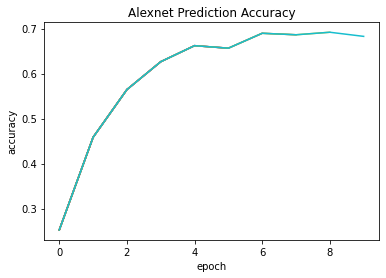

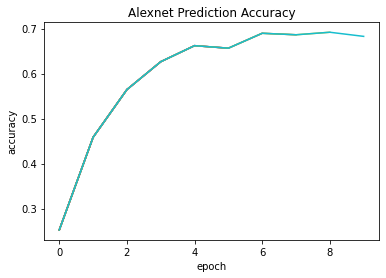

In [10]:
alexnet = AlexNet().to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=1e-4)
loss_fn = torch.nn.CrossEntropyLoss()

accuracies = []
for epoch in range(10):

    # Train loop
    alexnet.train()
    for batch in tqdm.notebook.tqdm(imagenette_train_loader):
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        output = alexnet(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

    # Eval loop
    alexnet.eval()
    total_correct = 0
    for batch in tqdm.notebook.tqdm(imagenette_val_loader):
        image, labels = batch
        image = image.to(device)
        labels = labels.to(device)
        
        output = alexnet(image)
        predictions = torch.argmax(output, dim=1)
        num_correct = torch.sum(predictions == labels)
        total_correct += num_correct

    # Visualize accuracy
    accuracy = total_correct / len(imagenette_val)
    accuracies.append(accuracy.item())
    plt.plot(accuracies)
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Alexnet Prediction Accuracy')
    display.clear_output(wait=True)
    display.display(plt.gcf())

## Part 4: Ethics
Read [this article](https://www.nytimes.com/2019/11/19/technology/artificial-intelligence-bias.html) from the NYT giving a number of perspectives on combating bias in AI. While the the technical problems they bring up e.g. unbalanced datasets can be addressed with technical solutions, the interviewees also discuss social and societal issues which are harder to solve.

What group, entity, or person do you think should be responsible for ensuring computer vision systems don't harm more people than they help them, and why?

Write your ~200-300 word opinion below, and post it to your pod's slack for discussion.

In [ ]:
vision_enforcement = '' #@param {type:"string"}

## Part 5: Get To Know Your Pod

Talk with at least two of your podmates and ask what did they wanted to do when they were growing up. Have things changed since then?

In [ ]:
growing_up = '' #@param {type:"string"}

# Submission

Once you're done, click on 'Share' and add the link to the box below.

In [ ]:
link = '' #@param {type:"string"}

In [ ]:
import time
import numpy as np
import urllib.parse
from IPython.display import IFrame

t7 = time.time()

#@markdown #Run Cell to Show Airtable Form
#@markdown ##**Confirm your answers and then click "Submit"**


def prefill_form(src, fields: dict):
  '''
  src: the original src url to embed the form
  fields: a dictionary of field:value pairs,
  e.g. {"pennkey": my_pennkey, "location": my_location}
  '''
  prefill_fields = {}
  for key in fields:
      new_key = 'prefill_' + key
      prefill_fields[new_key] = fields[key]
  prefills = urllib.parse.urlencode(prefill_fields)
  src = src + prefills
  return src



#autofill fields if they are not present
#a missing pennkey and pod will result in an Airtable warning
#which is easily fixed user-side.
try: my_pennkey;
except NameError: my_pennkey = ""

try: my_pod;
except NameError: my_pod = "Select"

try: developments;
except NameError: developments = ""

try: link;
except NameError: link = ""

try: vision_enforcement;
except NameError: vision_enforcement = ""

try: growing_up;
except NameError: growing_up = ""


fields = {"pennkey": my_pennkey,
          "pod": my_pod,
          "developments": developments,
          "link": link,
          "growing_up": growing_up,
          "vision_enforcement": vision_enforcement}

src = "https://airtable.com/embed/shrdREwKlfCi2BWex?"


#now instead of the original source url, we do: src = prefill_form(src, fields)
display.display(IFrame(src = prefill_form(src, fields), width = 800, height = 400))